# Zaimportowanie bibliotek

In [1]:
import matplotlib.pyplot as plt
from random import shuffle
from matplotlib.animation import PillowWriter
import random
import numpy as np
import pandas as pd
import time

# Implementacja potrzebnych funkcji

In [2]:
def initial_population(cities_list, n_population):
    """
    Generating initial population by shuffling the list of cities.
    This avoids generating all permutations, which is not efficient for large lists.

    Args:
    cities_list: List of city identifiers
    n_population: Number of individual solutions in the population
    
    Returns:
    List of randomly shuffled city orders (routes)
    """
    population = []
    for _ in range(n_population):
        individual = cities_list[:]
        random.shuffle(individual)
        population.append(individual)
    
    return population

In [3]:
def dist_two_cities(city_1, city_2):
    
    """
    Calculating the distance between two cities  
    Args:
    city_1: City one name 
    city_2: City two name
    Returns:
    Calculated Euclidean distance between two cities
    """
    
    city_1_coords = city_coords[city_1]
    city_2_coords = city_coords[city_2]
    return np.sqrt(np.sum((np.array(city_1_coords) - np.array(city_2_coords))**2))

In [4]:
def total_dist_individual(individual):
    
    """
    Calculating the total distance traveled by individual, 
    one individual means one possible solution (1 permutation)
    Args:
    individual: Individual list of cities 
    Returns:
    Total distance traveled 
    """
    
    total_dist = 0
    for i in range(0, len(individual)):
        if(i == len(individual) - 1):
            total_dist += dist_two_cities(individual[i], individual[0])
        else:
            total_dist += dist_two_cities(individual[i], individual[i+1])
    return total_dist

In [5]:
def fitness_prob(population):
    """
    Calculating the fitness probability 
    Args:
    population: Population  
    Returns:
    Population fitness probability 
    """
    total_dist_all_individuals = []
    for i in range (0, len(population)):
        total_dist_all_individuals.append(total_dist_individual(population[i]))    
    max_population_cost = max(total_dist_all_individuals)
    population_fitness = np.array([max_population_cost - d for d in total_dist_all_individuals])
    population_fitness_sum = sum(population_fitness)
    if population_fitness_sum == 0:
        population_fitness_probs = np.ones(len(population)) / len(population)
    else:
        population_fitness_probs = population_fitness / population_fitness_sum
    return population_fitness_probs

In [6]:
def roulette_wheel(population, fitness_probs):
    """
    Implement a selection strategy based on proportionate roulette wheel
    Selection.
    Args:
    population: population
    fitness_probs: fitness probabilities 
    Returns:
    selected individual
    """
    population_fitness_probs_cumsum = fitness_probs.cumsum()
    bool_prob_array = population_fitness_probs_cumsum < np.random.uniform(0,1,1)
    selected_individual_index = len(bool_prob_array[bool_prob_array == True]) - 1
    return population[selected_individual_index]

In [7]:
def tournament_selection(population, group_size):
    """
    Implement a selection strategy based on tournament
    Selection.
    Args:
    population: population
    group_size: size of group
    Returns:
    selected individual
    """
    group = random.sample(population, min(group_size, len(population)))
    group_distances = [total_dist_individual(group[i]) for i in range(group_size)]
    return group[np.argmin(group_distances)]

In [8]:
def crossover(parent_1, parent_2):
    """
    Implement mating strategy using simple crossover between two parents
    Args:
    parent_1: parent 1
    parent_2: parent 2 
    Returns:
    offspring 1
    offspring 2
    """
    n_cities_cut = len(cities_names) - 1
    cut = round(random.uniform(1, n_cities_cut))
    offspring_1 = []
    offspring_2 = []
    
    offspring_1 = parent_1 [0:cut]
    offspring_1 += [city for city in parent_2 if city not in offspring_1]
    
    
    offspring_2 = parent_2 [0:cut]
    offspring_2 += [city for city in parent_1 if city not in offspring_2]
    
    
    return offspring_1, offspring_2

In [9]:
def mutation(offspring):
    """
    Implement mutation strategy in a single offspring
    Args:
    offspring: offspring individual
    Returns:
    mutated offspring individual
    """
    n_cities_cut = len(cities_names) - 1
    index_1 = round(random.uniform(0, n_cities_cut))
    index_2 = round(random.uniform(0, n_cities_cut))

    temp = offspring [index_1]
    offspring[index_1] = offspring[index_2]
    offspring[index_2] = temp
    return(offspring)

In [10]:
def select_parent(population, selection_type, fitness_probs, tournament_size=4):
    """
    Implement mutation strategy in a single offspring
    Args:
    population: population
    selection_type: type of selection, roulette or tournament
    fitness_probs: fitness probabilities
    tournament_size: size of group in tournament selection, default 4.
    Returns:
    selected individual
    """
    if selection_type == "roulette":
        return roulette_wheel(population, fitness_probs)
    elif selection_type == "tournament":
        return tournament_selection(population, tournament_size)
    else:
        raise ValueError(f"Unknown selection type: {selection_type}")

# Parametry
- liczebność populacji,
- współczynnik krzyżowania
- współczynnik mutacji
- liczba pokoleń
- liczba i współrzędne miast

In [1]:
n_population = 200
crossover_per = 0.8
mutation_per = 0.2
n_generations = 200

Wybrano 30 miast

In [12]:
cities_num = 30
cities_names = [str(i) for i in range(cities_num)]
x = [round(random.uniform(0, 300), 2) for i in range(1, cities_num + 1)]
y = [round(random.uniform(0, 300), 2) for i in range(1, cities_num + 1)]
city_coords = dict(zip(cities_names, zip(x, y)))

# Główna funkcja programu

In [13]:
def run_ga(cities_names, n_population, n_generations,
           crossover_per, mutation_per, selection_type):
    
    population = initial_population(cities_names, n_population)
    fitness_probs = None
    
    # Pierwsza selekcja
    fitness_probs = fitness_prob(population) if selection_type == "roulette" else None
    
    parents_list = [select_parent(population, selection_type, fitness_probs) 
                    for _ in range(int(crossover_per * n_population))]

    # Krzyżowanie + mutacja
    offspring_list = []
    for i in range(0, len(parents_list), 2):
        offspring_1, offspring_2 = crossover(parents_list[i], parents_list[i+1])
        if random.random() < mutation_per:
            offspring_1 = mutation(offspring_1)
        if random.random() < mutation_per:
            offspring_2 = mutation(offspring_2)
        offspring_list.extend([offspring_1, offspring_2])

    # Inicjalna populacja mieszanego potomstwa
    mixed_offspring = parents_list + offspring_list
    fitness_probs = fitness_prob(mixed_offspring)
    sorted_indices = np.argsort(fitness_probs)[::-1]
    best_mixed_offsrping = [mixed_offspring[i] for i in sorted_indices[:n_population]]

    # Ewolucja
    best_paths = []
    best_distances = []
    mean_distances = []

    for _ in range(n_generations):
        fitness_probs = fitness_prob(best_mixed_offsrping) if selection_type == "roulette" else None
        parents_list = [select_parent(best_mixed_offsrping, selection_type, fitness_probs) 
                        for _ in range(int(crossover_per * n_population))]

        offspring_list = []
        for i in range(0, len(parents_list), 2):
            offspring_1, offspring_2 = crossover(parents_list[i], parents_list[i+1])
            if random.random() < mutation_per:
                offspring_1 = mutation(offspring_1)
            if random.random() < mutation_per:
                offspring_2 = mutation(offspring_2)
            offspring_list.extend([offspring_1, offspring_2])

        mixed_offspring = parents_list + offspring_list
        fitness_probs = fitness_prob(mixed_offspring)
        sorted_indices = np.argsort(fitness_probs)[::-1]
        best_mixed_offsrping = [mixed_offspring[i] for i in sorted_indices[:int(0.8 * n_population)]]

        # Dodajemy część starej populacji (będzie stanowić 20% nowego pokolenia)
        old_population_indices = [random.randint(0, n_population - 1) for _ in range(int(0.2 * n_population))]
        best_mixed_offsrping += [population[i] for i in old_population_indices]
        random.shuffle(best_mixed_offsrping)

        # Zapisywanie metryk
        distances = [total_dist_individual(ind) for ind in best_mixed_offsrping]
        best_idx = np.argmin(distances)
        best_distances.append(distances[best_idx])
        mean_distances.append(np.mean(distances))
        best_paths.append(best_mixed_offsrping[best_idx])

    return best_paths, best_distances, mean_distances


In [ ]:
start_time = time.time()
best_paths_t, best_distances_t, mean_distances_t = run_ga(
    cities_names, n_population, n_generations,
    crossover_per, mutation_per, "tournament"
)
print(f'Czas wykonania (selekcja turniejowa): {(time.time() - start_time):.2f} s')

In [15]:
start_time = time.time()
best_paths_r, best_distances_r, mean_distances_r = run_ga(
    cities_names, n_population, n_generations,
    crossover_per, mutation_per, "roulette"
)
print(f'Czas wykonania (selekcja ruletki): {(time.time() - start_time):.2f} s')

Czas wykonania (selekcja ruletki): 102.49 s


In [ ]:
def generate_roads(best_paths, best_distances, gif_title, plot_title):
    writer = PillowWriter(fps=10)
    fig, ax = plt.subplots(figsize=(16, 16))

    i = 1
    with writer.saving(fig, gif_title, 100):
        for path in best_paths:
            x_coord = []
            y_coord = []
            ax.clear()

            for city in path:
                x_value, y_value = city_coords[city]
                x_coord.append(x_value)
                y_coord.append(y_value)
                ax.text(x_value + 0.8, y_value + 0.8, str(city), fontsize=20, color='black')
            x_coord.append(x_coord[0])
            y_coord.append(y_coord[0])
            ax.plot(x_coord, y_coord, '-go', label='Best Route', linewidth=2.5)
            plt.title(f'Generation: {i}\nTotal distance: {round(best_distances[i-1], 2)}\n'
                         f'Population size: {n_population}\nCrossover: {crossover_per}\n'
                         f'Mutation: {mutation_per}', fontsize=15)
            writer.grab_frame()
            i += 1
    plt.suptitle(f'Ostatnia generacja z animacji ({plot_title})', fontsize=18)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [ ]:
generate_roads(best_paths_t, best_distances_t, "tournament.gif", "tournament")

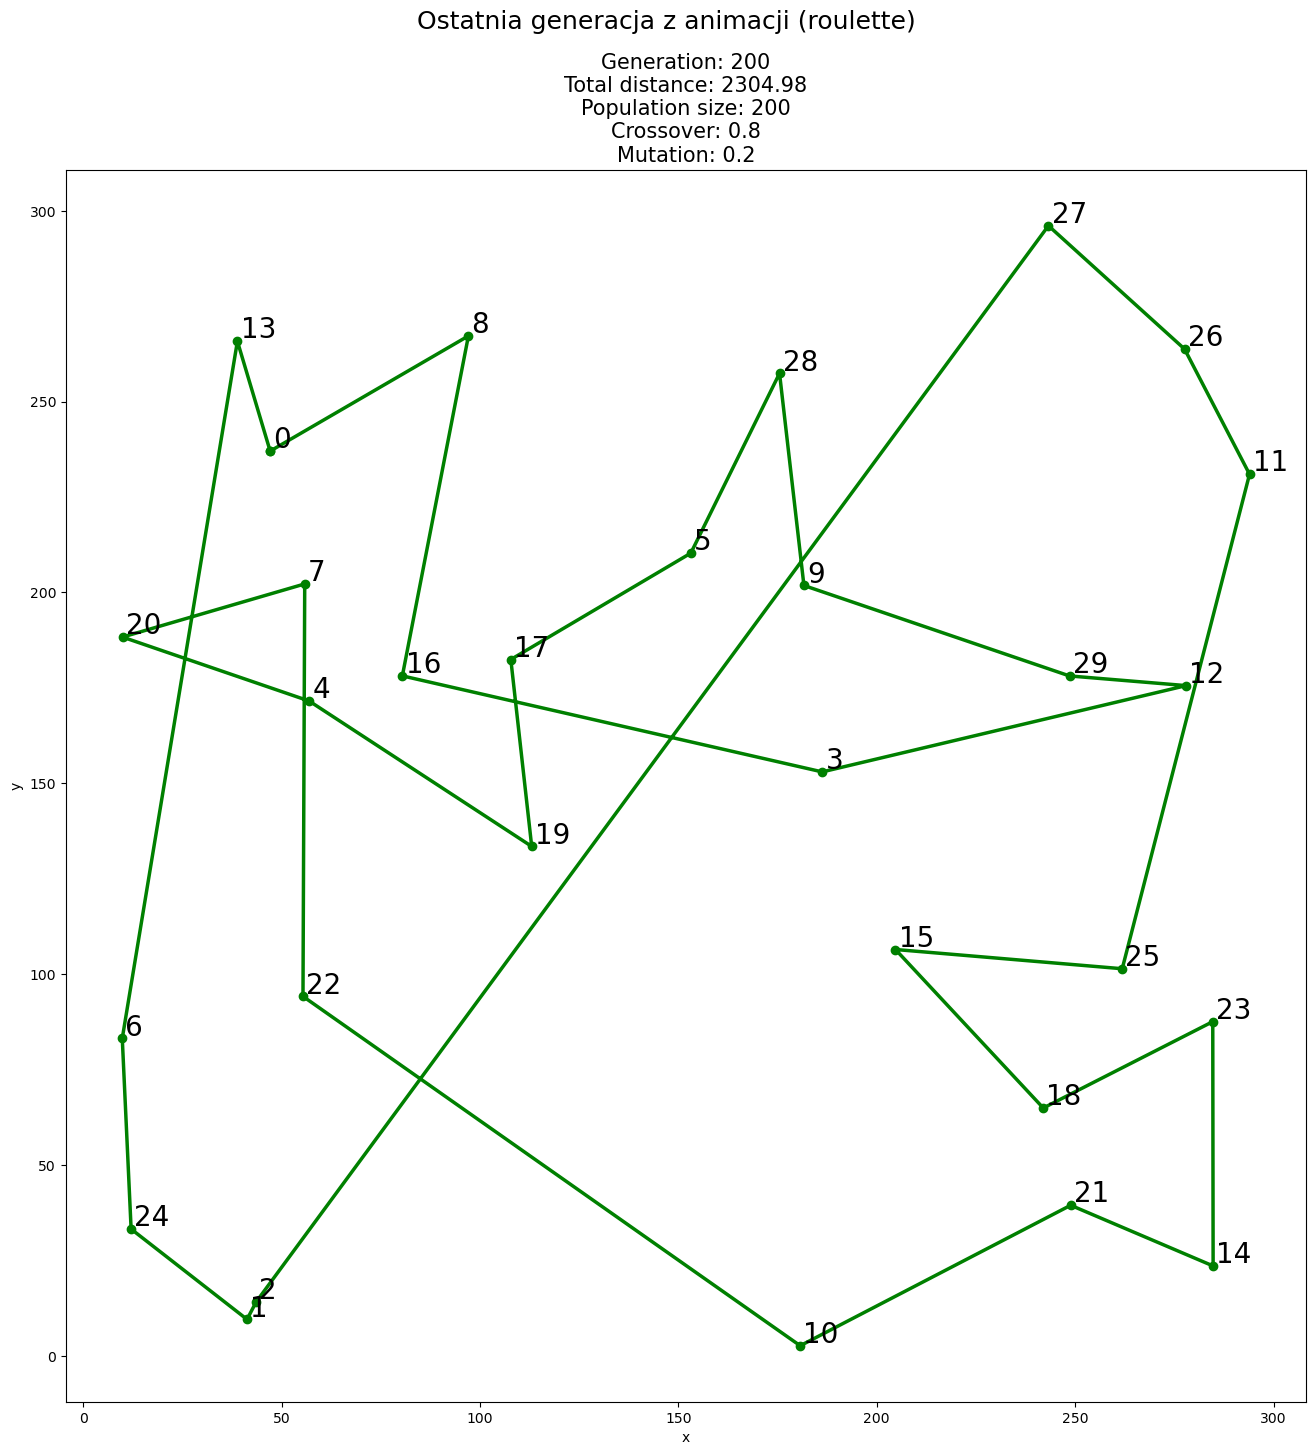

In [18]:
generate_roads(best_paths_r, best_distances_r, "roulette.gif", "roulette")

# Jak zmieniał się dystans na przestrzeni nowych generacji?

In [ ]:
def generate_comparison(best_distances, mean_distances, method):
    plt.plot(np.arange(1, n_generations+1), best_distances, label='best')
    plt.plot(np.arange(1, n_generations+1), mean_distances, label='mean')
    plt.xlabel('Kolejne pokolenia')
    plt.ylabel('Całkowity dystans')
    plt.title(f'Efekty ewolucji {method} (najkrótszy oraz średni dystans)')
    plt.legend()
    plt.show()

In [ ]:
generate_comparison(best_distances_t, mean_distances_t, 'tournament')

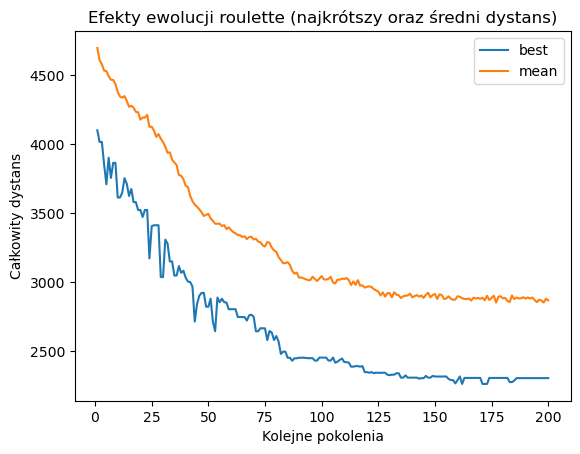

In [21]:
generate_comparison(best_distances_r, mean_distances_r, 'roulette')

# Porównanie metody ruletki oraz selekcji turniejowej

Na wykresach można zaobserwować, że dla obu metod trend wartości najlepszych osobników w kolejnych pokoleniach jest zbliżony do trendu wartości średniej całej populacji. Wyraźnie widać, że selekcja turniejowa szybciej osiąga rozwiązanie optymalne lub bliskie optymalnemu. Metoda ruletki potrzebuje do tego więcej generacji.

Podsumowując, na skuteczność algorytmu bardzo duży wpływ ma przede wszystkim metoda selekcji. Nie należy jednak pomijać parametrów takich jak: liczebność populacji, współczynnik krzyżowania, współczynnik mutacji oraz liczba pokoleń, które wspomagają działanie algorytmu. Nie bez znaczenia jest również proces sukcesji (w tym przypadku z częściowym zastępowaniem. Algorytm jest stabilniejszy, lecz może powodować utykanie w ekstremach lokalnych). Duży wpływ ma też liczba miast. Im jest ich więcej, tym trudniej znaleźć najlepsze rozwiązanie.